In [ ]:
# RESTART RUNTIME after running this cell!
!pip install -q transformers==4.36.2 datasets==2.17.1 nltk==3.8.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 92.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textblob 0.19.0 requires nltk>=3.9, but you have nltk 3.8.1 which is incompatible.
sentence-transformers 5.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.2 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2023.10.0 which is incompatible.


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers.optimization import AdamW  # ✅ FIXED
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import pandas as pd

df = pd.read_csv("lambani_sentences-2.csv")
print(df.columns.tolist())


['lambani', 'hindi']


In [ ]:
# Strip spaces and lowercase the column names
df.columns = df.columns.str.strip().str.lower()

# Now check
print(df.columns.tolist())




['lambani', 'hindi']


In [ ]:
df = df.dropna(subset=[ 'hindi', 'lambani'])
df.head()


,lambani,hindi
0,बाप बाजार गोच,पापा बाजार गए।
1,या खानों कार्रीच,माँ खाना बना रही है।
2,चाचबर रामरैच,बच्चे खेल रहे हैं।
3,तड़कों गण जापा च,गर्मी बहुत ज्यादा है।
4,मन पानी चानू,मुझे पानी चाहिए।


In [ ]:
#Train/Test Split


from sklearn.model_selection import train_test_split

# Set source and target
source_lang = "hindi"
target_lang = "lambani"

# Create train/val split (90/10)
train_texts, val_texts = train_test_split(df, test_size=0.1, random_state=42)

print(f"Train size: {len(train_texts)}, Validation size: {len(val_texts)}")


Train size: 989, Validation size: 110


In [ ]:
#Load Tokenizer
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [ ]:
#Define Custom Dataset
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_col, target_col, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.source_col = source_col
        self.target_col = target_col
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src = str(self.data.iloc[idx][self.source_col])
        tgt = str(self.data.iloc[idx][self.target_col])

        source = self.tokenizer(src, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt")
        target = self.tokenizer(tgt, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt")

        return {
            'input_ids': source['input_ids'].squeeze(),
            'attention_mask': source['attention_mask'].squeeze(),
            'labels': target['input_ids'].squeeze()
        }


In [ ]:
#Create DataLoaders
from torch.utils.data import DataLoader

train_dataset = TranslationDataset(train_texts, tokenizer, source_lang, target_lang)
val_dataset = TranslationDataset(val_texts, tokenizer, source_lang, target_lang)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [ ]:
#Define BART Model + Optimizer
import torch
from transformers import BartForConditionalGeneration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
#Training Loop
from tqdm import tqdm
import torch.nn as nn

num_epochs = 25
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1} => Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    torch.save(model.state_dict(), f"bart_epoch_{epoch+1}.pt")


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.44it/s]


Epoch 1 => Train Loss: 4.2306, Val Loss: 0.7055


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.04it/s]


Epoch 2 => Train Loss: 0.4796, Val Loss: 0.2668


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.20it/s]


Epoch 3 => Train Loss: 0.2793, Val Loss: 0.2270


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.10it/s]


Epoch 4 => Train Loss: 0.2414, Val Loss: 0.2041


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.20it/s]


Epoch 5 => Train Loss: 0.2170, Val Loss: 0.1943


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.16it/s]


Epoch 6 => Train Loss: 0.2037, Val Loss: 0.1862


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.06it/s]


Epoch 7 => Train Loss: 0.1909, Val Loss: 0.1733


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.27it/s]


Epoch 8 => Train Loss: 0.1805, Val Loss: 0.1643


Validating: 100%|██████████| 14/14 [00:01<00:00, 10.97it/s]


Epoch 9 => Train Loss: 0.1728, Val Loss: 0.1560


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.17it/s]


Epoch 10 => Train Loss: 0.1623, Val Loss: 0.1534


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.19it/s]


Epoch 11 => Train Loss: 0.1536, Val Loss: 0.1480


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.13it/s]


Epoch 12 => Train Loss: 0.1467, Val Loss: 0.1395


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.17it/s]


Epoch 13 => Train Loss: 0.1403, Val Loss: 0.1369


Validating: 100%|██████████| 14/14 [00:01<00:00, 10.95it/s]


Epoch 14 => Train Loss: 0.1337, Val Loss: 0.1248


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.19it/s]


Epoch 15 => Train Loss: 0.1260, Val Loss: 0.1221


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.22it/s]


Epoch 16 => Train Loss: 0.1198, Val Loss: 0.1173


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.11it/s]


Epoch 17 => Train Loss: 0.1145, Val Loss: 0.1130


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.02it/s]


Epoch 18 => Train Loss: 0.1073, Val Loss: 0.1035


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.08it/s]


Epoch 19 => Train Loss: 0.1025, Val Loss: 0.1019


Validating: 100%|██████████| 14/14 [00:01<00:00, 10.92it/s]


Epoch 20 => Train Loss: 0.0969, Val Loss: 0.0981


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.16it/s]


Epoch 21 => Train Loss: 0.0904, Val Loss: 0.0905


Validating: 100%|██████████| 14/14 [00:01<00:00, 10.68it/s]


Epoch 22 => Train Loss: 0.0835, Val Loss: 0.0896


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.16it/s]


Epoch 23 => Train Loss: 0.0780, Val Loss: 0.0844


Validating: 100%|██████████| 14/14 [00:01<00:00, 10.82it/s]


Epoch 24 => Train Loss: 0.0753, Val Loss: 0.0760


Validating: 100%|██████████| 14/14 [00:01<00:00, 11.04it/s]


Epoch 25 => Train Loss: 0.0682, Val Loss: 0.0737


In [ ]:
#Save Checkpoint
model.save_pretrained("bart-hindi-lambani-pos")
tokenizer.save_pretrained("bart-hindi-lambani-pos")


('bart-hindi-lambani-pos/tokenizer_config.json',
 'bart-hindi-lambani-pos/special_tokens_map.json',
 'bart-hindi-lambani-pos/vocab.json',
 'bart-hindi-lambani-pos/merges.txt',
 'bart-hindi-lambani-pos/added_tokens.json')

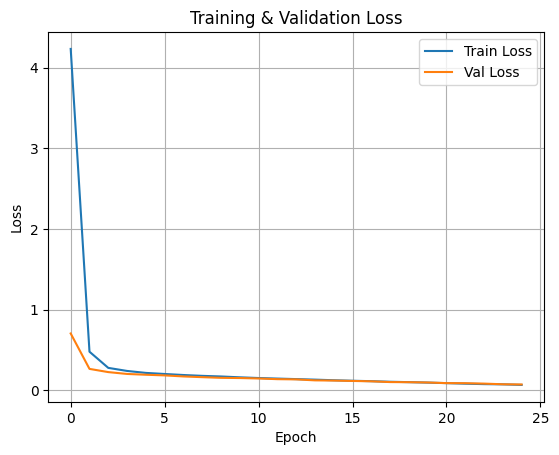

In [ ]:
#Plot Training vs Validation Loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_plot.png")
plt.show()

In [ ]:
!pip install --upgrade nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


In [ ]:
from fractions import Fraction as OrigFraction

class Fraction(OrigFraction):
    def __new__(cls, *args, **kwargs):
        kwargs.pop('_normalize', None)
        return super().__new__(cls, *args, **kwargs)

import nltk.translate.bleu_score
nltk.translate.bleu_score.Fraction = Fraction


In [ ]:
#BLEU Score Evaluation
from nltk.translate.bleu_score import corpus_bleu

def evaluate_bleu(model, dataloader, tokenizer):
    model.eval()
    predictions, references = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)
            preds = [tokenizer.decode(g, skip_special_tokens=True) for g in outputs]
            refs = [tokenizer.decode(t, skip_special_tokens=True) for t in labels]

            predictions.extend(preds)
            references.extend([[ref.split()] for ref in refs])  # BLEU expects list of lists

    score = corpus_bleu(references, [pred.split() for pred in predictions])
    return score

bleu_score = evaluate_bleu(model, val_loader, tokenizer)
print(f"BLEU Score: {bleu_score:.4f}")


Evaluating: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]

BLEU Score: 0.2181


In [ ]:
!pip install bert-score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
import torch
from tqdm import tqdm
from bert_score import score as bert_score

def evaluate_bertscore(model, dataloader, tokenizer, device="cuda"):
    model.eval()
    predictions, references = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating with BERTScore"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)
            preds = [tokenizer.decode(g, skip_special_tokens=True) for g in outputs]
            refs = [tokenizer.decode(t, skip_special_tokens=True) for t in labels]

            predictions.extend(preds)
            references.extend(refs)

    P, R, F1 = bert_score(predictions, references, lang="en", verbose=True)
    return {
        "precision": P.mean().item(),
        "recall": R.mean().item(),
        "f1": F1.mean().item()
    }

bertscore_results = evaluate_bertscore(model, val_loader, tokenizer)
print("BERTScore:", bertscore_results)


Evaluating with BERTScore: 100%|██████████| 14/14 [00:16<00:00,  1.18s/it]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 1.61 seconds, 68.30 sentences/sec
BERTScore: {'precision': 0.9481762051582336, 'recall': 0.9458332657814026, 'f1': 0.9468912482261658}


In [ ]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=dc0dfb8bea696f6fa3f9dc95e5277ea4418cd04ca5e06e47f48d92814539f55f
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer
from tqdm import tqdm
import torch

def evaluate_rouge(model, dataloader, tokenizer, device="cuda"):
    model.eval()
    predictions, references = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating with ROUGE"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)
            preds = [tokenizer.decode(g, skip_special_tokens=True) for g in outputs]
            refs = [tokenizer.decode(t, skip_special_tokens=True) for t in labels]

            predictions.extend(preds)
            references.extend(refs)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {"rouge1": [], "rouge2": [], "rougeL": []}

    for ref, pred in zip(references, predictions):
        s = scorer.score(ref, pred)
        for k in scores.keys():
            scores[k].append(s[k].fmeasure)  # can also use precision/recall

    avg_scores = {k: sum(v) / len(v) for k, v in scores.items()}
    return avg_scores

rouge_scores = evaluate_rouge(model, val_loader, tokenizer)
print("ROUGE Scores:", rouge_scores)


Evaluating with ROUGE: 100%|██████████| 14/14 [00:15<00:00,  1.10s/it]

ROUGE Scores: {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}


In [ ]:
import pandas as pd

# 1. Load CSV
df = pd.read_csv("lambani_sentences-2.csv")  # adjust path if needed
print(df.head())

# 👉 Make sure your CSV has columns like: ["ID", "Hindi", "Konkani"]
# Let's assume:
#   - Hindi = source sentence
#   - Konkani = reference/target translation

sources = df["hindi"].astype(str).tolist()
references = df["lambani"].astype(str).tolist()

# 2. Get predictions from your model
# (Here I’ll put a placeholder loop — replace with your own model call)
predictions = []
for src in sources:
    # Example: If using a Hugging Face translation model
    # pred = model.generate(tokenizer(src, return_tensors="pt"))
    # pred_text = tokenizer.decode(pred[0], skip_special_tokens=True)
    pred_text = "dummy prediction for: " + src  # placeholder
    predictions.append(pred_text)

# 3. Normalize texts
def normalize(text):
    return text.lower().strip()

predictions = [normalize(p) for p in predictions]
references = [normalize(r) for r in references]

# 4. Evaluate
from bert_score import score
from datasets import load_metric

# BERTScore
P, R, F1 = score(predictions, references, lang="hi")  # if Hindi, change lang code accordingly
print("BERTScore:", {
    "precision": P.mean().item(),
    "recall": R.mean().item(),
    "f1": F1.mean().item()
})

# ROUGE
rouge = load_metric("rouge")
results = rouge.compute(predictions=predictions, references=references)
print("ROUGE:", {k: v.mid.fmeasure for k, v in results.items()})

            lambani                  hindi
0     बाप बाजार गोच         पापा बाजार गए।
1  या खानों कार्रीच   माँ खाना बना रही है।
2      चाचबर रामरैच     बच्चे खेल रहे हैं।
3  तड़कों गण जापा च  गर्मी बहुत ज्यादा है।
4      मन पानी चानू       मुझे पानी चाहिए।


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERTScore: {'precision': 0.6673024296760559, 'recall': 0.7078971266746521, 'f1': 0.6867765188217163}


/tmp/ipython-input-37916799.py:45: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")
/usr/local/lib/python3.12/dist-packages/datasets/load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


ROUGE: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}


In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
import evaluate
rouge = evaluate.load("rouge")

results = rouge.compute(predictions=predictions, references=references)
print("ROUGE:", results)


ROUGE: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}


In [ ]:
# Quick sanity check
for i in range(5):
    print("SOURCE:     ", sources[i])
    print("REFERENCE:  ", references[i])
    print("PREDICTION: ", predictions[i])
    print("-" * 40)

# Ensure no NaN/empty strings
predictions = [p if isinstance(p, str) and p.strip() != "" else " " for p in predictions]
references = [r if isinstance(r, str) and r.strip() != "" else " " for r in references]

# Normalize
def normalize(text):
    return text.lower().strip()

predictions = [normalize(p) for p in predictions]
references = [normalize(r) for r in references]

# Re-run ROUGE using 'evaluate' (new API)
import evaluate
rouge = evaluate.load("rouge")

results = rouge.compute(predictions=predictions, references=references)
print("ROUGE:", results)


SOURCE:      पापा बाजार गए।
REFERENCE:   बाप बाजार गोच
PREDICTION:  dummy prediction for: पापा बाजार गए।
----------------------------------------
SOURCE:      माँ खाना बना रही है।
REFERENCE:   या खानों कार्रीच
PREDICTION:  dummy prediction for: माँ खाना बना रही है।
----------------------------------------
SOURCE:      बच्चे खेल रहे हैं।
REFERENCE:   चाचबर रामरैच
PREDICTION:  dummy prediction for: बच्चे खेल रहे हैं।
----------------------------------------
SOURCE:      गर्मी बहुत ज्यादा है।
REFERENCE:   तड़कों गण जापा च
PREDICTION:  dummy prediction for: गर्मी बहुत ज्यादा है।
----------------------------------------
SOURCE:      मुझे पानी चाहिए।
REFERENCE:   मन पानी चानू
PREDICTION:  dummy prediction for: मुझे पानी चाहिए।
----------------------------------------
ROUGE: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}


In [ ]:
#Test on Unseen Sentences


def translate(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    outputs = model.generate(**inputs, max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example usage:
hindi_input = "मैं स्कूल जा रही हु"
konkani_output = translate(hindi_input)
print(f"Hindi ➡ Konkani: {konkani_output}")


Hindi ➡ Konkani: मा स्कूल जा रीच
